In [2]:
import pandas as pd


In [3]:
gl = pd.read_csv("guestList.csv")

In [4]:
gl.head()

,Date,Guest,Primetime,Start_Hour,Program
0,April 23 2020 Thursday,Steven Hahn;Stephen Lewia;Nicole Saphier,1,23,Fox News Network FOX NEWS @ NIGHT
1,May 19 2020 Tuesday,Pat Toomey,0,16,Fox News Network YOUR WORLD WITH NEIL CAVUTO
2,April 22 2020 Wednesday,Stew Leonard Jr.,0,16,Fox News Network YOUR WORLD WITH NEIL CAVUTO
3,May 21 2020 Thursday,Tom Ridge,0,16,Fox News Network YOUR WORLD WITH NEIL CAVUTO
4,June 18 2020 Thursday,Brad Smith,0,16,Fox News Network YOUR WORLD WITH NEIL CAVUTO


In [9]:
fox = open('fox_text.txt','r')
fox = fox.readlines()

In [10]:
lines = pd.DataFrame(columns=['Date','Start_Hour','Program','Speaker','Line'])

In [16]:
for l in range(100):
    print(l)
    transcript = fox[l]
    meta = gl.iloc[l,:]
    chunks = transcript.split('|')
    line = ''
    spkr = ''
    for c in chunks:
        if ':' in c:
            lines.loc[len(lines)] = [meta['Date'],meta['Start_Hour'],meta['Program'],spkr,line]
            #print(spkr + ':' + line)
            c = c.split(':')
            spkr = c[0]
            line = c[1]
        else:
            line += c
    lines.loc[len(lines)] = [meta['Date'],meta['Start_Hour'],meta['Program'],spkr,line]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [17]:
lines.head()

,Date,Start_Hour,Program,Speaker,Line
0,April 23 2020 Thursday,23,Fox News Network FOX NEWS @ NIGHT,,(BEGIN VIDEO CLIP)
1,April 23 2020 Thursday,23,Fox News Network FOX NEWS @ NIGHT,UNIDENTIFIED FEMALE,-- thank you has gotten me censored. Can you ...
2,April 23 2020 Thursday,23,Fox News Network FOX NEWS @ NIGHT,"LAURA INGRAHAM, FOX NEWS HOST","Karen, it's just reprehensible. Unbelievable ..."
3,April 23 2020 Thursday,23,Fox News Network FOX NEWS @ NIGHT,"SHANNON BREAM, FOX NEWS ANCHOR","A lot of breaking news. All right, Laura, tha..."
4,April 23 2020 Thursday,23,Fox News Network FOX NEWS @ NIGHT,$484 Billion Relief For Small Business And Hos...,Heat And Sun Weaken Coronavirus; Poor Prelim ...


In [25]:
print(lines.iloc[923,:])

Date                                    August 22 2020 Saturday
Start_Hour                                                   22
Program                  Fox News Network THE GREG GUTFELD SHOW
Speaker                   JULIA LOUIS-DREYFUS, AMERICAN ACTRESS
Line           So what did you think about Kamala Harris's s...
Name: 923, dtype: object


In [22]:
lines.to_csv('fox_lines.csv')

In [35]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [33]:
test = nlp(lines.iloc[923,4])
for token in test:
    print(token, token.idx)

  0
So 1
what 4
did 9
you 13
think 17
about 23
Kamala 29
Harris 36
's 42
speech 45
last 52
night 57
? 62


## First attempt at cleaning

In [38]:
import re
from typing import List

import spacy
from spacy.tokens import Doc
from tqdm import tqdm


class SpacyPreprocessor:
    def __init__(
        self,
        spacy_model=None,
        remove_numbers=False,
        remove_special=True,
        pos_to_remove=None,
        remove_stopwords=False,
        lemmatize=False,
    ):
        """
        Preprocesses text using spaCy
        :param remove_numbers: Whether to remove numbers from text
        :param remove_stopwords: Whether to remove stopwords from text
        :param remove_special: Whether to remove special characters (including numbers)
        :param pos_to_remove: list of PoS tags to remove
        :param lemmatize:  Whether to apply lemmatization
        """

        self._remove_numbers = remove_numbers
        self._pos_to_remove = pos_to_remove
        self._remove_stopwords = remove_stopwords
        self._remove_special = remove_special
        self._lemmatize = lemmatize

        if not spacy_model:
            self.model = spacy.load("en_core_web_sm")
        else:
            self.model = spacy_model

    @staticmethod
    def download_spacy_model(model="en_core_web_sm"):
        print(f"Downloading spaCy model {model}")
        spacy.cli.download(model)
        print(f"Finished downloading model")

    @staticmethod
    def load_model(model="en_core_web_sm"):
        return spacy.load(model, disable=["ner", "parser"])

    def tokenize(self, text) -> List[str]:
        """
        Tokenize text using a spaCy pipeline
        :param text: Text to tokenize
        :return: list of str
        """
        doc = self.model(text)
        return [token.text for token in doc]

    def preprocess_text(self, text) -> str:
        """
        Runs a spaCy pipeline and removes unwanted parts from text
        :param text: text string to clean
        :return: str, clean text
        """
        doc = self.model(text)
        return self.__clean(doc)

    def preprocess_text_list(self, texts=List[str]) -> List[str]:
        """
        Runs a spaCy pipeline and removes unwantes parts from a list of text.
        Leverages spaCy's `pipe` for faster batch processing.
        :param texts: List of texts to clean
        :return: List of clean texts
        """
        clean_texts = []
        for doc in tqdm(self.model.pipe(texts)):
            clean_texts.append(self.__clean(doc))

        return clean_texts

    def __clean(self, doc: Doc) -> str:

        tokens = []
        # POS Tags removal
        if self._pos_to_remove:
            for token in doc:
                if token.pos_ not in self._pos_to_remove:
                    tokens.append(token)
        else:
            tokens = doc

        # Remove Numbers
        if self._remove_numbers:
            tokens = [
                token for token in tokens if not (token.like_num or token.is_currency)
            ]

        # Remove Stopwords
        if self._remove_stopwords:
            tokens = [token for token in tokens if not token.is_stop]
        # remove unwanted tokens
        tokens = [
            token
            for token in tokens
            if not (
                token.is_punct or token.is_space or token.is_quote or token.is_bracket
            )
        ]

        # Remove empty tokens
        tokens = [token for token in tokens if token.text.strip() != ""]

        # Lemmatize
        if self._lemmatize:
            text = " ".join([token.lemma_ for token in tokens])
        else:
            text = " ".join([token.text for token in tokens])

        if self._remove_special:
            # Remove non alphabetic characters
            text = re.sub(r"[^a-zA-Z\']", " ", text)
        # remove non-Unicode characters
        text = re.sub(r"[^\x00-\x7F]+", "", text)

        text = text.lower()

        return text


if __name__ == "__main__":
    spacy_model = SpacyPreprocessor.load_model()
    preprocessor = SpacyPreprocessor(spacy_model=spacy_model, lemmatize=True, remove_numbers=True)
    clean_text = preprocessor.preprocess_text("spaCy is awesome! 123")
    print(clean_text)

spacy be awesome


In [48]:
spacy_model = SpacyPreprocessor.load_model()
preprocessor = SpacyPreprocessor(spacy_model=spacy_model, lemmatize=True, remove_numbers=True, remove_stopwords = True)
clean_text = preprocessor.preprocess_text(lines.iloc[110,4])
print(clean_text)

heat sun weaken coronavirus poor prelim result remdesivir trial leaked online vaccine treat prescribe example prescribe call suboxone buprenorphine treatment opioid use disorder grateful able california unfortunately p a  nation allow archaic law


In [72]:
#cleaning
lines['Cleaned'] = lines['Line'].apply(lambda x: (preprocessor.preprocess_text(x)))

In [74]:
#getting number of tokens
lines['Num_Tokens'] = lines['Cleaned'].apply(lambda x: (len(x.split())))

In [79]:
import numpy as np
print(f"The average amount of tokens in a statement is: {np.mean(lines['Num_Tokens'])}")

The average amount of tokens in a statement is: 26.685899553940196


In [82]:
lines["id"] = lines['Date'] + lines['Start_Hour'].astype(str) + lines['Program']
print(f"The average amount of statements in a transcript is: {len(lines) / len(pd.unique(lines['id']))}")

The average amount of statements in a transcript is: 220.1090909090909


In [75]:
lines.head()

,Date,Start_Hour,Program,Speaker,Line,Cleaned,Num_Tokens
0,April 23 2020 Thursday,23,Fox News Network FOX NEWS @ NIGHT,,(BEGIN VIDEO CLIP),begin video clip,3
1,April 23 2020 Thursday,23,Fox News Network FOX NEWS @ NIGHT,UNIDENTIFIED FEMALE,-- thank you has gotten me censored. Can you ...,thank get censor believe think amendment right...,15
2,April 23 2020 Thursday,23,Fox News Network FOX NEWS @ NIGHT,"LAURA INGRAHAM, FOX NEWS HOST","Karen, it's just reprehensible. Unbelievable ...",karen reprehensible unbelievable democrats sha...,14
3,April 23 2020 Thursday,23,Fox News Network FOX NEWS @ NIGHT,"SHANNON BREAM, FOX NEWS ANCHOR","A lot of breaking news. All right, Laura, tha...",lot break news right laura thank begin tonight...,12
4,April 23 2020 Thursday,23,Fox News Network FOX NEWS @ NIGHT,$484 Billion Relief For Small Business And Hos...,Heat And Sun Weaken Coronavirus; Poor Prelim ...,heat sun weaken coronavirus poor prelim result...,87


## Trying Some Crazy Stuff

In [49]:
#importing required libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import nltk

import spacy

nltk.download('stopwords')

nlp=spacy.load('en_core_web_sm',disable=['parser', 'ner'])




[nltk_data] Downloading package stopwords to C:\Users\Seth
[nltk_data]     Benson\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [54]:
#importing the Stopwords to use them

stop_words = stopwords.words('english')


In [50]:
data = lines['Line']

In [51]:
#cleaning the text 

def tokeniz(sentences):

    for sentence in sentences:

        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

processed_data = list(tokeniz(data))

In [55]:


#Building Bigram & Trigram Models

bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)

trigram = gensim.models.Phrases(bigram[processed_data], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram_mod = gensim.models.phrases.Phraser(trigram)



#function to filter out stopwords

def remove_stopwords(texts):

    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]



#function to create bigrams

def create_bigrams(texts):

    return [bigram_mod[doc] for doc in texts]



#function to create trigrams

def create_trigrams(texts):

    [trigram_mod[bigram_mod[doc]] for doc in texts]



#function for lemmatization

def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):

    texts_op = []

    for sent in texts:

        doc = nlp(" ".join(sent))

        texts_op.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

    return texts_op



#removing stopwords, creating bigrams and lemmatizing the text

data_wo_stopwords = remove_stopwords(processed_data)

data_bigrams = create_bigrams(data_wo_stopwords)

data_lemmatized = lemmatize(data_bigrams, allowed_postags=[ 'NOUN', 'ADJ', 'VERB'])



#printing the lemmatized data

print(data_lemmatized[:3])



#creating a dictionary

gensim_dictionary = corpora.Dictionary(data_lemmatized)



texts = data_lemmatized



#building a corpus for the topic model

gensim_corpus = [gensim_dictionary.doc2bow(text) for text in texts]



#printing the corpus we created above.

print(gensim_corpus[:3]) 



#we can print the words with their frequencies.

[[(gensim_dictionary[id], freq) for id, freq in cp] for cp in gensim_corpus[:4]] 



#creating the LDA model 

lda_model = gensim.models.ldamodel.LdaModel(

   corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=20, random_state=100, 

   update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True

)


#calculating model perplexity

perplexity = lda_model.log_perplexity(gensim_corpus)



#printing model perplexity

print(perplexity)


[['begin', 'video', 'clip'], ['get', 'censor', 'think', 'first', 'amendment', 'guess', 'democratic', 'party', 'show', 'end', 'video', 'clip'], ['unbelievable', 'shameful', 'disgusting', 'time', 'tonight', 'shannon_bream', 'night', 'take']]
[[(0, 1), (1, 1), (2, 1)], [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)], [(13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]]
-16.33743505948827


In [63]:
x = []
p = []
for i in range(20):
   lda_model = gensim.models.ldamodel.LdaModel(
      corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=(i+1)*2, random_state=100   )
   #calculating model perplexity
   perplexity = lda_model.log_perplexity(gensim_corpus)

   #printing model perplexity

   x.append((i+1)*2)
   p.append(perplexity)
   print(x)
   print(perplexity)


[2]
-7.437345948514628
[2, 4]
-7.474740570920777
[2, 4, 6]
-7.513426993267782
[2, 4, 6, 8]
-7.615063158090618
[2, 4, 6, 8, 10]
-7.870397797177672
[2, 4, 6, 8, 10, 12]
-8.301187086423226
[2, 4, 6, 8, 10, 12, 14]
-8.559599615034585
[2, 4, 6, 8, 10, 12, 14, 16]
-8.715447275652965
[2, 4, 6, 8, 10, 12, 14, 16, 18]
-8.88190033588804
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
-9.042670071061346
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
-9.206258697189858
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
-9.368069970654973
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
-9.531017238022931
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
-9.699508773390063
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
-9.861117929780747
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
-10.025432472209998
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34]
-10.189676969260073
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]
-10.346050480103633
[2, 4, 6, 8, 10, 12,

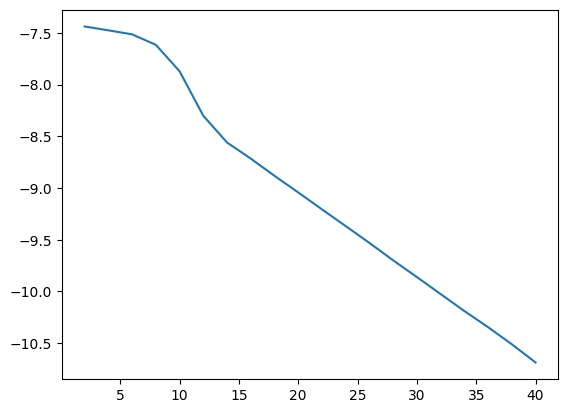

In [64]:
prep_plot = plt.plot(x,p)
plt.show()

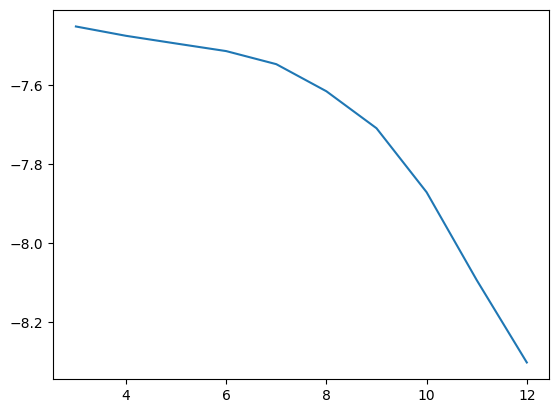

In [66]:
x = []
p = []
for i in range(3,13):
   lda_model = gensim.models.ldamodel.LdaModel(
      corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=(i), random_state=100   )
   #calculating model perplexity
   perplexity = lda_model.log_perplexity(gensim_corpus)

   #printing model perplexity

   x.append((i))
   p.append(perplexity)
   #print(x)
   #print(perplexity)
prep_plot = plt.plot(x,p)
plt.show()
